# Implement a custom Autoencoder with Koopman layer

## Version Control

To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
2) Preprocess Data
3) Make sure sim data is different for different ground parameters
4) Validation data has different batch size. Address when HP training
5) Address semi graident issue for K^m*z in linearity loss

## Setup

In [1]:
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
from tensorflow import keras

import  numpy as np
import pandas as pd

import matplotlib.colors as mcol

import time 
import os

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


## Data

### Read full data

In [5]:
doggo_train = pd.read_csv('Rigid Ground Data/train_data.csv', sep=',').values
doggo_test =pd.read_csv('Rigid Ground Data/test_data.csv', sep=',').values
doggo_validation = pd.read_csv('Rigid Ground Data/validation_data.csv', sep=',').values

### Extract theta, theta_dot, gamma and gamma_dot columns

In [6]:
input_dim = 4
output_dim = 4

doggo_train = doggo_train[:,0:input_dim]
doggo_test = doggo_test[:,0:input_dim]
doggo_validation = doggo_validation[:,0:input_dim]

### Define trajectory lengths in each batch

In [7]:
trajLength = 64 #length of each trajectory in the dataset
numTraj = 40 #total number of trajectories in the dataset
numTraj_val = 4
batch_size = int(256) # Number of snapshots in each batch
numTraj_batch = int(batch_size/trajLength)
input_dim = 4

num_batches_train = int(trajLength*numTraj/batch_size) ## num_batches = trajLength*numTraj/batch_size 
num_batches_val = int(trajLength*numTraj_val/batch_size)

In [10]:
num_batches_val

1

### Normalize the data from 0 to 1

In [13]:
# Normalize the data
min_val = tf.reduce_min(doggo_train)
max_val = tf.reduce_max(doggo_train)

doggo_train = (doggo_train - min_val) / (max_val - min_val)
doggo_validation = (doggo_validation - min_val) / (max_val - min_val)
doggo_test = (doggo_test - min_val) / (max_val - min_val)

train_data = tf.cast(doggo_train, tf.float32)
validation_data = tf.cast(doggo_validation, tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(doggo_test, tf.float32)

In [14]:
x_train = train_data
y_train = train_data
tf.shape(x_train)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2560,    4])>

### Plot data

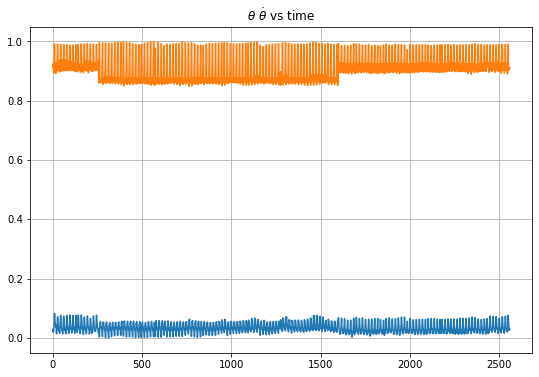

In [15]:
plt.grid()
plt.plot(train_data[:,0:2]) #51 samples for each trajectory
plt.title(r"$\theta$ $\dot \theta$ vs time")
plt.show()

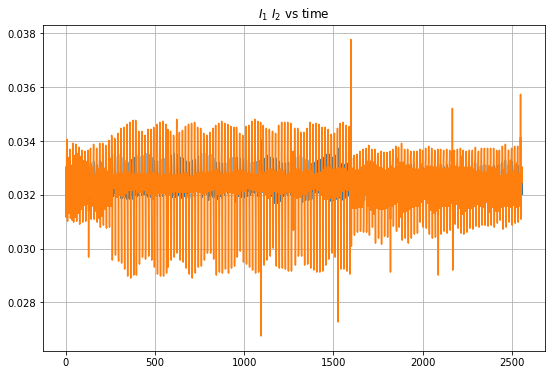

In [16]:
plt.grid()
plt.plot(train_data[:,2:4]) #51 samples for each trajectory
plt.title(r"$I_1$ $I_2$ vs time")
plt.show()

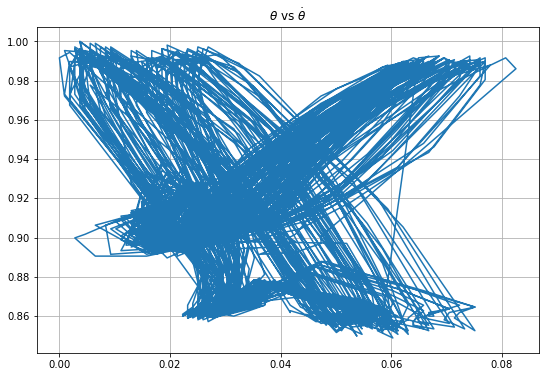

In [19]:
plt.grid()
plt.plot(train_data[:,0], train_data[:,1]) #51 samples for each trajectory
plt.title(r"$\theta$ vs $\dot \theta$")
plt.show()

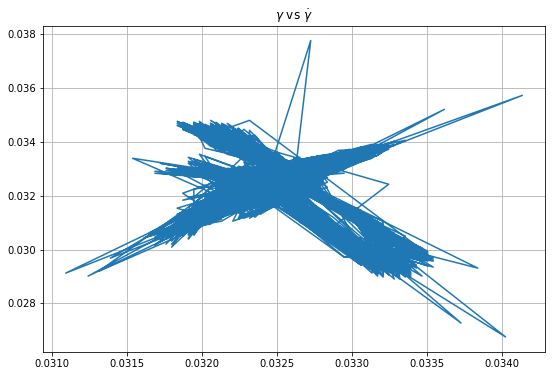

In [14]:
plt.grid()
plt.plot(train_data[:,2], train_data[:,3]) #51 samples for each trajectory
plt.title(r"$\gamma$ vs $\dot \gamma$")
plt.show()

# Custom Model definition

## Encoder

In [15]:
class EncoderLayer(keras.layers.Layer):
    """
    Custom class to create a encoder layer
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * x + b: tensor
        linear combination of weights times input + bias for the layer
    """
    
    def __init__(self, units=32, name=None):
        super(EncoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Encoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, inputs):
        #print("Encoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(inputs, self.w) + self.b

In [16]:
class EncoderModel(keras.Model):
    """
    Custom Model to create an encoder with one input
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    """
    
    def __init__(self, name=None):
        super(EncoderModel, self).__init__(name=name)
        self.enc0 = EncoderLayer(16)
        self.enc1 = EncoderLayer(32)
        self.enc2 = EncoderLayer(64)
        self.enc3 = EncoderLayer(64)
        self.enc4 = EncoderLayer(16)
        self.enc5 = EncoderLayer(16)
        self.outputLayer = EncoderLayer(16)

    def call(self, input):
        x = input
        x = self.enc0(x)
        x = tf.nn.tanh(x)
        x = self.enc1(x)
        x = tf.nn.tanh(x)
        x = self.enc2(x)
        x = tf.nn.tanh(x)
        x = self.enc3(x)
        x = tf.nn.tanh(x)
        x = self.enc4(x)
        x = tf.nn.tanh(x)
        x = self.enc5(x)
        x = tf.nn.tanh(x)

        # Encoder output layer
        z = self.outputLayer(x)
        z = tf.nn.tanh(z)
        return z

## Koopman

In [17]:
class KoopmanLayer(keras.layers.Layer):
    """
    Custom class to calculate the Koopman operator K on latent variables
    Adds a linear loss as mse(Z2-Z2_tilde)
    
    Parameters
    ----------
    Z: tensor 
        inputs are the latent variabes (output from encoder)
        input dimension is (m, 128)
        m is the number of time snapshots for each input dimension of X
        128 is the number of latent varibales (observables)

    Return
    ----------
    Z: tensor
        return the original input Z 

    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    Z2_tilde: tensor
        return the prediction by linearity from K (z2_tilde = K^m * z(1,:))
    """

    def __init__(self, trajLength, numTraj_batch):
        super(KoopmanLayer, self).__init__()
        self.trajLength = trajLength
        self.numTraj_batch = numTraj_batch

    def build(self, Z):
        # Initialize K as a weight
            self.K =  self.add_weight(
                name = 'Koopman_weight',
                shape=(Z[-1], Z[-1]),
                initializer="random_normal",
                trainable=True,
            )

    def timeShift(self,Z,latent_dim):
        '''
        Shifts trajectories one time step
        Parameters:
        -----------
            Z: tensor
                Batch data of latent variables (in the lifted space)
                
            latent_dim: tensor shape
                Dimension of the lifted space (columns of Z)
        '''
        Z1 = []
        z1 = []
        Z2 = []

        for i in range(self.numTraj_batch):
            Z1.append(Z[i*self.trajLength:(i+1)*self.trajLength-1,:])
            Z2.append(Z[i*self.trajLength+1:(i+1)*self.trajLength,:])
            z1.append(Z[i*self.trajLength,:])
        return tf.reshape(Z1, [-1, latent_dim]), tf.reshape(Z2, [-1, latent_dim]), tf.reshape(z1, [-1, latent_dim])       

    def call(self, Z):
        latent_dim = tf.shape(Z)[1]
        shift_len = (self.trajLength-1)*self.numTraj_batch # length of rows for forward time shifted Z
        Z1, Z2, z1 = self.timeShift(Z,latent_dim)

        # Find Z2_tilde
        Z2_tilde = tf.zeros([shift_len, latent_dim], dtype=tf.float32)
        for traj in range(self.numTraj_batch): # loop over numnber of traj
            for m in range(self.trajLength-1): #loop over snapshots in each traj               
                 indices = tf.constant([[traj*(self.trajLength-1)+m]])
                 if m == 0:
                    K = self.K 
                    # Matrix matvec works out to get Kz' and returns as row vector
                    updates = [tf.linalg.matvec(K, z1[traj,:])] #updates the row tensor at index = indices 
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
                 else:
                    K = tf.matmul(K,self.K)
                    updates = [tf.linalg.matvec(K, z1[traj,:])]
                    Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)
           
        # Find linear loss
        Linear_loss = tf.reduce_mean(tf.square(tf.subtract(Z2,Z2_tilde)))
        self.add_loss(Linear_loss)
        
        # prints for debugging dimensions
        #print("Koopman layer, K",tf.shape(K))
        #print("Koopman layer, m",tf.shape(m))
        #print("Koopman layer, Z",tf.shape(Z))
        #print("Koopman layer, z1",tf.shape(z1))
        #print("Koopman layer, Z2 ",tf.shape(Z2))
        #print("Koopman layer, Z2_tilde",tf.shape(Z2_tilde))
        
        return Z, tf.matmul(Z1,self.K), Z2_tilde,

In [18]:
class Koopman_Model(keras.Model):
    """
    Custom Model to create an encoder with koopman layer
    
    Parameters
    ----------
    input: tensor 
        z - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    z: tensor
        Latent variables of x in the lifted space
    
    Z2_hat: tensor
        return the prediction from K (z2_hat = K*z1)

    z2_tilde: tensor
        Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    """
    
    def __init__(self, trajLength, numTraj_batch, name=None):
        super(Koopman_Model, self).__init__(name=name)
        self.koopman = KoopmanLayer(trajLength,numTraj_batch)


    def call(self, input):
        z = input
        z, Z2_hat, z2_tilde = self.koopman(z)
        return z, Z2_hat, z2_tilde

## Decoder

In [19]:
class DecoderLayer(keras.layers.Layer):
    """
    Custom class to create a decoder layer with two inputs
    
    Parameters
    ----------
    units: number of units in the layer 
        units are assigned to the layer at the time of initialization
    
    input_shape: shape of the input (output from previous layer)
        input_shape is used to build the weight matrix at the time of call
        
    Return
    ----------
    W.T * input1 + b: tensor
        linear combination of weights times input1 + bias for the layer
        
    W.T * input2 + b: tensor
        linear combination of weights times input2 + bias for the layer

    W.T * input3 + b: tensor
        linear combination of weights times input3 + bias for the layer
    """

    def __init__(self, units=32, name=None):
        super(DecoderLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weight',
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), initializer="zeros", trainable=True
        )
        #print("Decoder Layer, weight dimension:",tf.shape(self.w))

    def call(self, input1, input2, input3):
        #print("Decoder Layer, output dimension:",tf.shape(tf.matmul(inputs, self.w) + self.b))
        return tf.matmul(input1, self.w) + self.b, tf.matmul(input2, self.w) + self.b, tf.matmul(input3, self.w) + self.b

In [20]:
class DecoderModel(keras.Model):
    """
    Custom Model to create a decoder with two inputs
    
    Parameters
    ----------
    input 1: tensor 
        z - the lifted output of the koopman layer (encoder output)
    
    input 2: tensor 
        z2_tilde - obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Prediction of the original state inputs x (label values are forward time shifted x)

    x2_tilde: tensor
        Prediction obtained by linearity from K 
    
    """
    
    def __init__(self, output_dim=4, name=None):
        super(DecoderModel, self).__init__(name=name)
        self.dec0 = DecoderLayer(64)
        self.dec1 = DecoderLayer(64)
        self.dec2 = DecoderLayer(32)
        self.dec3 = DecoderLayer(64)
        self.outputLayer = DecoderLayer(output_dim)

    def call(self, input1, input2, input3):
        z = input1
        z2_hat = input2
        z2_tilde = input3

        z, z2_hat, z2_tilde = self.dec0(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        z, z2_hat, z2_tilde = self.dec1(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        z, z2_hat, z2_tilde = self.dec2(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)

        z, z2_hat, z2_tilde = self.dec3(z, z2_hat, z2_tilde)
        z = tf.nn.tanh(z)
        z2_hat = tf.nn.tanh(z2_hat)
        z2_tilde = tf.nn.tanh(z2_tilde)


        # Decoder output layer
        x_hat, x2_hat, x2_tilde = self.outputLayer(z, z2_hat, z2_tilde)
        #x_hat = tf.nn.elu(x_hat)
        #x2_hat = tf.nn.elu(x2_hat)
        #x2_tilde = tf.nn.elu(x2_tilde)

        return x_hat, x2_hat, x2_tilde

## Koopman Autoencoder

In [21]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, trajLength, numTraj, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = Koopman_Model(trajLength, numTraj)
        self.dec = DecoderModel(output_dim)

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_hat, z2_tilde = self.koopman(z)
        x_hat, x2_hat, x2_tilde = self.dec(z, z2_hat, z2_tilde)
        return x_hat, x2_hat, x2_tilde

# Custom Training Loop

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
train_dataset = train_dataset.batch(batch_size)

In [33]:
class MyStaticModel():
    def __init__(self, input_dim, batch_size, trajLength, num_batches_train, num_batches_val):
        # Initialize constants
        self.batch_size = batch_size
        self.trajLength = int(trajLength) #should be int
        self.numtraj_batch = int(self.batch_size/self.trajLength) # should be int
        self.num_batches_train = num_batches_train
        self.num_batches_val = num_batches_val

        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        self.graphCounter = 0 

    ######################################  LOSS FUNCTIONS  ###################################################
    def tot_loss(self, model, x, x_hat, x2_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        #alpha1 = 0.1, alpha2 = 1e-7, alpha3 = 1e-15
        alpha1 = 0.1
        alpha2 = 1e-7
        alpha3 = 1e-15

        #print("In loss function x", tf.shape(x))
        #print("In loss function x_hat", tf.shape(x_hat))
        #print("In loss function x2_hat", tf.shape(x2_hat))
        #print("In loss function x2_tilde", tf.shape(x2_tilde))

        x2 = []
        x2_SP = []
        x2_tilde_SP = []
        for i in range(self.numtraj_batch):
            predict_length = self.trajLength-1
            x2.append(x[i*self.trajLength+1:(i+1)*self.trajLength]) # forward time shift x to get x2
            x2_SP.append(x[i*self.trajLength+1:i*self.trajLength+predict_length+1]) # forward time shift x to get x2 for Sp timesteps
            #x2_tilde_SP.append(x2_tilde[i*self.trajLength:i*self.trajLength+predict_length]) # get Sp timesteps from x2_tilde
            x2_tilde_SP = x2_tilde

        #print("In loss function x2", tf.shape(x2))
        #print("In loss function x2_SP", tf.shape(x2_SP))
        #print("In loss function x2_tilde_SP", tf.shape(x2_tilde_SP))
        
        x2 = tf.reshape(x2, [-1, x.shape[-1]])
        x2_SP = tf.reshape(x2_SP, [-1, x.shape[-1]])
        x2_tilde_SP = tf.reshape(x2_tilde_SP, [-1, x.shape[-1]])

        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2_SP,x2_tilde_SP)))

        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])

        Linf_loss = tf.add(tf.norm(tf.subtract(x,x_hat), ord=np.inf), tf.norm(tf.subtract(x2,x2_hat), ord=np.inf))
        return alpha1*(recon_loss+predict_loss) + alpha2*Linf_loss + alpha3*lossL2 + sum(model.losses)

    ###############################################  GRAPH FUNCTIONS #########################################################

    def graphPlot(self, error, error_min, error_max, error_val, error_min_val, error_max_val):
        '''
        Graph plots for loss over all epochs
        Parameters:
        error: list
            Training Loss Error for all epochs
        error_val: list
            Validation Loss Error for all epochs
        '''
        saveFiles = True
        imgPath = 'graphs/'
        csvPath = 'csvFiles/'

        csvFileName = 'epochLosses.csv'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making graph folder. Folder already exists...")

            try:
                os.mkdir(csvPath)
            except:
                print("Tried making csv folder. Folder already exists...")
        
        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Training Loss")
        plt.plot(error_val, label = "Validation Loss")
        textTitle = "All Epoch Loss %d" % self.graphCounter
        self.graphCounter += 1
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight') 
        plt.close()

        # Save data into csv file
        csvDict = {'Epoch Training Loss': error, 'Epoch Training Min Loss': error_min, 'Epoch Training Max Loss': error_max,
                    'Epoch Validation Loss': error_val, 'Epoch Validation Min Loss' : error_min_val, 
                    'Epoch Validation Max Loss': error_max_val}
        df = pd.DataFrame(csvDict)
        df.to_csv(csvPath+csvFileName)

    
    def graphBatchLossPlot(self, epochNum, error, error_val):
        saveFiles = True
        imgPath = 'graphs/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")

        plt.figure(figsize=(10,10))
        plt.xlabel('time', fontsize=16)
        plt.ylabel('x', fontsize=16)
        plt.plot(error, label="Batch Training Loss")
        plt.plot(error_val, label="Batch Validation Loss")
        textTitle = "BatchLoss_Epoch_%d" % (epochNum)
        plt.title(textTitle)
        plt.legend()
        if saveFiles:
            plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight')
        plt.close() 

    
    def graphEigenfunctions(self, model, K):
        saveFiles = True
        imgPath = 'graphs/eigenfunctions/'
        if saveFiles:
            try:
                os.mkdir(imgPath)
            except:
                print("Tried making folder. Folder already exists...")

        x1 = tf.linspace(-1,1,256)
        x2 = tf.linspace(-1,1,256)
        x1, x2 = tf.meshgrid(x1, x2)
        X = tf.reshape([[x1],[x2]], [-1, 2])

        Z = model.enc(X)
        complex_Z = tf.complex(Z, tf.zeros(tf.shape(Z))) # make Z complex with zero complex part

        eig_values, right_eig_vectors = tf.linalg.eig(tf.squeeze(K))
        W = tf.transpose(tf.linalg.inv(right_eig_vectors))
        Psi = tf.matmul(complex_Z,W)

        eig_dominant = tf.abs(eig_values)
        counter = 0
        for eig in eig_values:
            cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","w","r"])
            #normalize = mpl.colors.Normalize(vmin=np.min(Psi[:,counter]), vmax=np.max(Psi[:,counter]))
            plt.figure(counter)
            fig, axs = plt.subplots(2)
            
            p1 = axs[0].scatter(x1, x2, c=tf.abs(Psi[:,counter]).numpy(), cmap=cm1)
            fig.colorbar(p1, ax=axs[0])
            fig_title1 = "|Psi| %0.04f + %0.04f i"%(tf.math.real(eig),tf.math.imag(eig)) 
            axs[0].set_title(fig_title1)
            
            p2 = axs[1].scatter(x1, x2, c=tf.math.angle(Psi[:,counter]).numpy(), cmap=cm1)
            fig.colorbar(p2, ax=axs[1])
            fig_title2 = "angle(Psi) %0.04f + %0.04f i"%(tf.math.real(eig),tf.math.imag(eig))  
            axs[1].set_title(fig_title2)

            fig.tight_layout()
            textTitle = "Psi_%0.04f_epoch%d"%(eig, counter)
            counter += 1
            if saveFiles:
                plt.savefig(imgPath+textTitle+'.png', bbox_inches='tight')
            plt.close('all') 

    ###############################################     FIT FUNCTION        #########################################################

    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(0.0001)

        epochs = 10000     
        
        epoch_train_loss = [] 
        epoch_train_min_loss = []
        epoch_train_max_loss = []

        epoch_validation_loss = []
        epoch_validation_min_loss = []
        epoch_validation_max_loss = []


        start_time_total = time.time()
        for epoch in range(epochs):

            print("\nStart of epoch %d" % (epoch))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []

            
            ###############################################     Training loop     ###################################################
            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                with tf.GradientTape() as tape:
                    reconstruction, prediction, linearity = model(x_batch_train)

                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, prediction, linearity)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                              
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/self.num_batches_train
            avg_min_train_loss = np.amin(batch_train_loss_list)/self.num_batches_train
            avg_max_train_loss = np.amax(batch_train_loss_list)/self.num_batches_train

            epoch_train_loss.append(avg_train_loss)
            epoch_train_min_loss.append(avg_min_train_loss)
            epoch_train_max_loss.append(avg_max_train_loss)
            print("Average training loss at epoch %d: %.7f"% (epoch, float(avg_train_loss)))


            ###############################################   Validaiton  loop     ###################################################
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                reconstruction_val, pred_val, linearity_val = model(x_batch_val)
                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, pred_val, linearity_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_min_loss.append(np.amin(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_max_loss.append(np.amax(batch_validation_loss_list)/self.num_batches_val)

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches_val}")
            print("Time taken: %.2fs" % (time.time()- start_time_total))
            #self.graphBatchLossPlot(epoch, batch_train_loss_list, batch_validation_loss_list)
            #K = model.koopman.get_weights()
            #self.graphEigenfunctions(model, K)

        self.graphPlot(epoch_train_loss, epoch_train_min_loss, epoch_train_max_loss, epoch_validation_loss, 
                        epoch_validation_min_loss, epoch_validation_max_loss)
        print("Total time taken: %.2fs" % (time.time() - start_time_total))

In [34]:
Training_class = MyStaticModel(input_dim, batch_size, trajLength, num_batches_train, num_batches_val)
koopmanAEModel = Koopman_AE_Model(trajLength, numTraj_batch, name="Koopman_AE_Model")
Training_class.fit(koopmanAEModel,x=train_data, y=train_data, validation_data=validation_data, batch_size=batch_size)


Start of epoch 0
Average training loss at epoch 0: 0.0433277
Epoch val loss: 0.038393545895814896
Time taken: 3.91s

Start of epoch 1
Average training loss at epoch 1: 0.0344027
Epoch val loss: 0.03326833248138428
Time taken: 7.69s

Start of epoch 2
Average training loss at epoch 2: 0.0296600
Epoch val loss: 0.028396356850862503
Time taken: 11.44s

Start of epoch 3
Average training loss at epoch 3: 0.0251524
Epoch val loss: 0.02390131726861
Time taken: 15.20s

Start of epoch 4
Average training loss at epoch 4: 0.0209316
Epoch val loss: 0.019789012148976326
Time taken: 18.96s

Start of epoch 5
Average training loss at epoch 5: 0.0171711
Epoch val loss: 0.01612802967429161
Time taken: 22.77s

Start of epoch 6
Average training loss at epoch 6: 0.0138268
Epoch val loss: 0.01289806142449379
Time taken: 26.62s

Start of epoch 7
Average training loss at epoch 7: 0.0109030
Epoch val loss: 0.010093613527715206
Time taken: 30.41s

Start of epoch 8
Average training loss at epoch 8: 0.0083719
Epo

# Plots on Train data

### Reconstruction

In [35]:
input = x_train
out1, out2, out3 = koopmanAEModel(input)

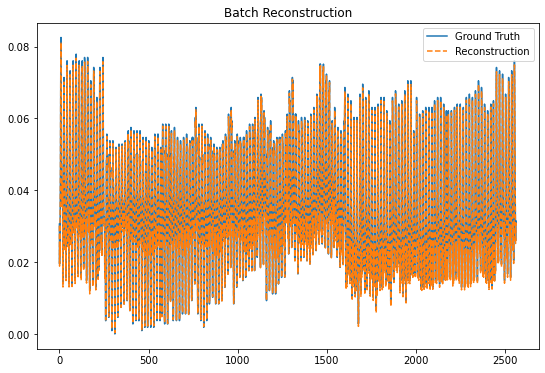

In [36]:
plt.title("Batch Reconstruction")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(input[:,0], label = "Ground Truth")
plt.plot(out1[:,0], '--', label="Reconstruction")
plt.legend()

### Linear Prediction

In [37]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

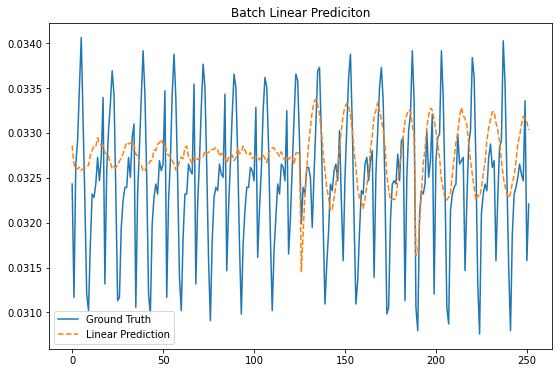

In [38]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2[:,3], label = "Ground Truth")
plt.plot(out3[:,3], '--', label="Linear Prediction")
plt.legend()

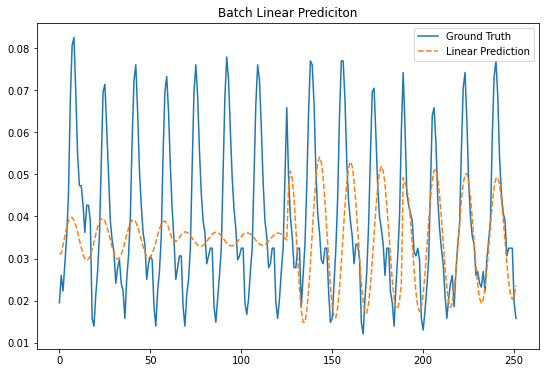

In [42]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2[:,0], label = "Ground Truth")
plt.plot(out3[:,0], '--', label="Linear Prediction")
plt.legend()

### Error graphs

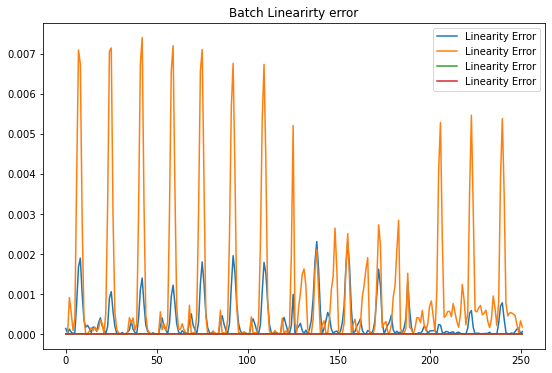

In [43]:
plt.title("Batch Linearirty error")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot((tf.square(tf.subtract(x2,out3))), label = "Linearity Error")
plt.legend()

### Koopman Matrix

In [44]:
K = koopmanAEModel.koopman.get_weights()
print(K)
tf.shape(K)

[array([[ 0.05106818,  0.10494978, -0.02182881, -0.14497244, -0.18895036,
        -0.22382486,  0.08928006, -0.04118623,  0.11211713, -0.11186412,
        -0.16201851, -0.0314092 ,  0.20205975,  0.0714668 , -0.15657401,
        -0.18606865],
       [ 0.16764632,  0.3924305 ,  0.15083705, -0.13052538,  0.10296515,
         0.20158094,  0.04394943,  0.09503251, -0.0445569 , -0.20394678,
         0.0326797 ,  0.12804261, -0.04725274,  0.07342201,  0.07998551,
        -0.04563393],
       [-0.00630544,  0.05180995,  0.05569527, -0.00525501,  0.07644451,
         0.15700054, -0.01749892,  0.13149194, -0.14489827,  0.0742004 ,
        -0.03802241,  0.02740026, -0.34337208,  0.15441395,  0.02287326,
        -0.02235597],
       [-0.14244854,  0.05756951, -0.05583943,  0.31570664,  0.14612104,
         0.27008528, -0.05836614,  0.02207329, -0.13690442,  0.02138621,
         0.29354525,  0.04022082, -0.16111094,  0.07313334, -0.19907662,
         0.1340903 ],
       [ 0.00964392,  0.0644594 ,  

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 1, 16, 16])>

# Save the Model

In [45]:
koopmanAEModel.save('checkpoints/doggo_Trained_Model')

INFO:tensorflow:Assets written to: checkpoints/doggo_Trained_Model\assets


# Load the Model

In [51]:
new_model = tf.keras.models.load_model('checkpoints/doggo_Trained_Model', compile=False)
new_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model_4 (EncoderMode multiple                  8480      
_________________________________________________________________
koopman__model_4 (Koopman_Mo multiple                  256       
_________________________________________________________________
decoder_model_4 (DecoderMode multiple                  9700      
Total params: 18,436
Trainable params: 18,436
Non-trainable params: 0
_________________________________________________________________


# Plots on Test Data

In [77]:
input = test_data
new_out1, new_out2, new_out3 = new_model(input)

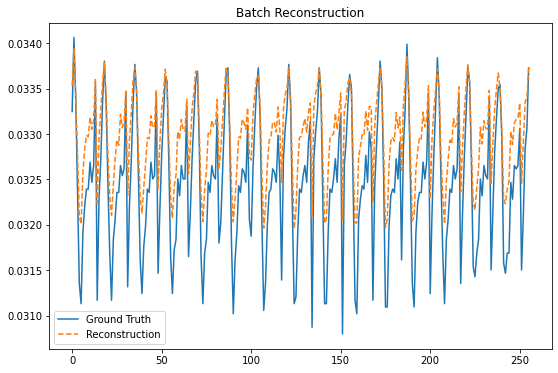

In [78]:
plt.title("Batch Reconstruction")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(input[:,3], label = "Ground Truth")
plt.plot(new_out1[:,3], '--', label="Reconstruction")
plt.legend()

In [79]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

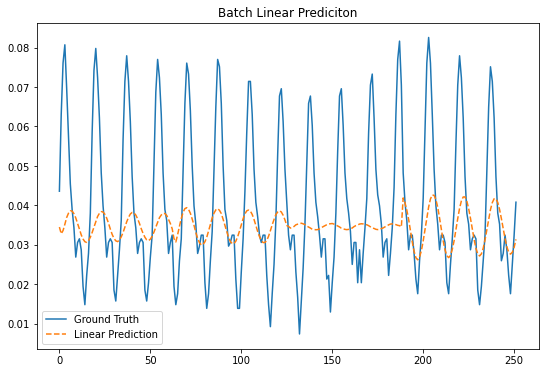

In [80]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2[:,0], label = "Ground Truth")
plt.plot(new_out3[:,0], '--', label="Linear Prediction")
plt.legend()